load packages

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib import rcParams
import pickle
import numpy as np
from glob import glob
from rdkit import Chem

plt.style.use("seaborn-ticks")
rcParams.update(
    {
        "font.family": "sans-serif",
        "axes.labelsize": 18,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "xtick.major.size": 7,
        "ytick.major.size": 7,
        "xtick.major.width": 2.0,
        "ytick.major.width": 2.0,
        "font.size": 20,
        "axes.linewidth": 2.0,
        "lines.dashed_pattern": (5, 2.5),
        "lines.markersize": 10,
        "lines.linewidth": 3,
        "lines.markeredgewidth": 2,
        "lines.markeredgecolor": "k",
        "legend.fontsize": 16,
        "legend.frameon": True,
    }
)

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors

def compute_descriptors(smi_ls):
    """ Computes descriptors """
    keep_idx = []
    descriptors = []

    for i, smiles in enumerate(smi_ls):
        
        descrip = compute_ecfp(smiles)
        if descrip is not None:
            descriptors.append(descrip)
        else:
            return None
    return np.vstack(descriptors)

def compute_ecfp(smiles: str):
    try:
        mol = Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None

    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp).reshape((1, -1))
    
    return None

def get_coverage(chem_df):

    fig, ax = plt.subplots(figsize=(8,8))
    for data in list(set(chem_df.data)):
        plt.plot(chem_df[chem_df.data==data].PCA_0,\
             chem_df[chem_df.data==data].PCA_1,"o", alpha=0.8,ms=5, \
                markeredgewidth=0.35, label=data+" (N="+str(chem_df[chem_df.data==data]\
                    .count()[0])+')')
    plt.legend()
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')

    plt.close()
    
    return ax


def get_distribution(csv_path):

    df=pd.read_csv(csv_path)
    fig, ax = plt.subplots(figsize=(8,6))
    df['label'].hist()
    x_label=csv_path.split('/')[-1].split('.')[0]
    ax.set_xlabel(x_label)
    ax.set_ylabel('Frequency')
    plt.close()
    
    return ax, x_label

def check_ring(smi):
    mol=Chem.MolFromSmiles(smi)
    return mol.GetRingInfo().NumRings()

In [4]:
repo_dir='/ocean/projects/cts180021p/shang9/published_repos/envchemGNN/'

Figure S1: visualizing chemical space coverage

In [5]:
data_full_path=glob(repo_dir+'data/model_input/*split/*.csv')
data_path=[x for x in data_full_path if ('OH' in x)==False and ('fup' in x)==False ]

In [6]:
df=pd.DataFrame({})
for data in data_path:
    df_=pd.read_csv(data)[['SMILES', 'label']]
    df_['data']=data.split('/')[-1].split('.')[0]
    df=pd.concat([df, df_])

In [7]:
descriptors = compute_descriptors(df["SMILES"])

[23:39:24] WARNING: not removing hydrogen atom without neighbors
[23:39:25] WARNING: not removing hydrogen atom without neighbors
[23:39:25] WARNING: not removing hydrogen atom without neighbors
[23:39:25] WARNING: not removing hydrogen atom without neighbors
[23:39:25] WARNING: not removing hydrogen atom without neighbors
[23:39:25] WARNING: not removing hydrogen atom without neighbors
[23:39:25] WARNING: not removing hydrogen atom without neighbors
[23:39:25] WARNING: not removing hydrogen atom without neighbors
[23:39:25] WARNING: not removing hydrogen atom without neighbors


In [8]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(descriptors)
df["PCA_0"], df["PCA_1"] = X_pca[:,0], X_pca[:,1]

In [13]:
ax=get_coverage(df)
fig=ax.get_figure()
fig.savefig('output/chem_cov.svg')

Figure S2: distribution

In [11]:
data_path_dis=[x for x in data_path if ('split' in x)==True]

In [14]:
for csv_path in data_path_dis:
    ax, x_label=get_distribution(csv_path)
    print(x_label)
    fig=ax.get_figure()
    fig.savefig('output/'+x_label+'.svg')

BCF
ESOL
Clint
SO4_react
O3_react


Figure S3: ring analysis

In [15]:
dfs=[]
smiles_list=[]
for csv_path in data_path_dis:
    name=csv_path.split('/')[-1].split('.')[0]
    df=pd.read_csv(csv_path)
    df['Nring']=df['SMILES'].apply(lambda x: check_ring(x))
    df['name']=name
    df=df.sort_values(['Nring'],ascending=False)
    print(name,(df['Nring']>0).sum(),'/',df.count()[0],(df['Nring']>0).sum()*100/df.count()[0] )
    smiles_list+=[list(df['SMILES'])[0]]
    dfs+=[df]

BCF 904 / 1056 85.60606060606061
ESOL 826 / 1144 72.2027972027972
Clint 4402 / 4422 99.54771596562641
SO4_react 395 / 557 70.91561938958708
O3_react 573 / 759 75.49407114624506


[23:47:12] WARNING: not removing hydrogen atom without neighbors
[23:47:12] WARNING: not removing hydrogen atom without neighbors
[23:47:12] WARNING: not removing hydrogen atom without neighbors
[23:47:12] WARNING: not removing hydrogen atom without neighbors
[23:47:12] WARNING: not removing hydrogen atom without neighbors
[23:47:12] WARNING: not removing hydrogen atom without neighbors
[23:47:12] WARNING: not removing hydrogen atom without neighbors
[23:47:12] WARNING: not removing hydrogen atom without neighbors
[23:47:12] WARNING: not removing hydrogen atom without neighbors


five molecules displayed in SI

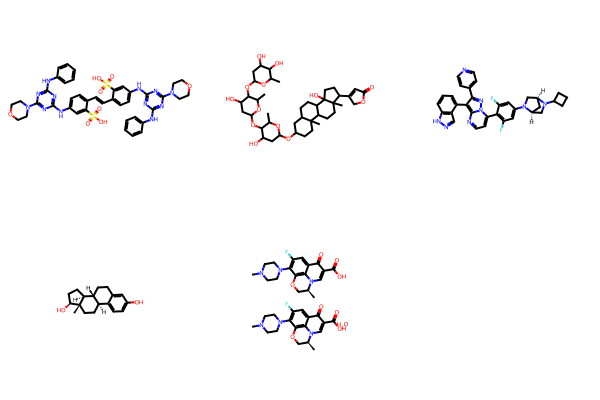

In [16]:
smiles_list
mol_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
Chem.Draw.MolsToGridImage(mol_list,molsPerRow=3, useSVG=True)

Table 2: result analysis

In [17]:
import pandas as pd
import numpy as np
from glob import glob

ECFP row

In [19]:
print('vanilla features:')
result_list=glob('../model/feature-based/result_1/*/*csv')

for result in result_list:
    feature_based=pd.read_csv(result).sort_values(['RMSE_mean'],ignore_index=True)
    ecfp_based=feature_based[feature_based['Feat']=='ecfp'].reset_index(drop=True)
    print(result.split('/')[-2], "% 0.3f"% ecfp_based['RMSE_mean'].loc[0], '+/-', "% 0.3f"% ecfp_based['RMSE_std'].loc[0],\
        ecfp_based['Model'].loc[0], ecfp_based['Feat'].loc[0])

print('scaled features:')
result_list=glob('../model/feature-based/result_stand_scaler_1/*/*csv')

for result in result_list:
    feature_based=pd.read_csv(result).sort_values(['RMSE_mean'],ignore_index=True)
    ecfp_based=feature_based[feature_based['Feat']=='ecfp'].reset_index(drop=True)
    print(result.split('/')[-2], "% 0.3f"% ecfp_based['RMSE_mean'].loc[0], '+/-', "% 0.3f"% ecfp_based['RMSE_std'].loc[0],\
        ecfp_based['Model'].loc[0], ecfp_based['Feat'].loc[0])

vanilla features:
SO4_react  0.797 +/-  0.000 rf ecfp
ESOL  1.185 +/-  0.057 rf ecfp
O3_react  2.262 +/-  0.000 gb ecfp
Clint  0.914 +/-  0.093 nn ecfp
BCF  0.857 +/-  0.041 rf ecfp
scaled features:
SO4_react  0.740 +/-  0.000 svm ecfp
ESOL  1.185 +/-  0.066 rf ecfp
O3_react  2.262 +/-  0.000 gb ecfp
Clint  1.043 +/-  0.032 nn ecfp
BCF  0.851 +/-  0.045 rf ecfp


best feature-based row

In [24]:
print('vanilla features:')
result_list=glob('../model/feature-based/result_1/*/*csv')

for result in result_list:
    feature_based=pd.read_csv(result).sort_values(['RMSE_mean'],ignore_index=True)
    print(result.split('/')[-2], "% 0.3f"% feature_based['RMSE_mean'].loc[0], '+/-', "% 0.3f"% feature_based['RMSE_std'].loc[0],\
        feature_based['Model'].loc[0], feature_based['Feat'].loc[0])

print('scaled features:')
result_list=glob('../model/feature-based/result_stand_scaler_1/*/*csv')

for result in result_list:
    feature_based=pd.read_csv(result).sort_values(['RMSE_mean'],ignore_index=True)
    print(result.split('/')[-2], "% 0.3f"% feature_based['RMSE_mean'].loc[0], '+/-', "% 0.3f"% feature_based['RMSE_std'].loc[0],\
        feature_based['Model'].loc[0], feature_based['Feat'].loc[0])

vanilla features:
SO4_react  0.675 +/-  0.000 rf mordred
ESOL  0.613 +/-  0.042 gb mordred
O3_react  2.111 +/-  0.000 rf maccs
Clint  0.863 +/-  0.048 rf mordred
BCF  0.670 +/-  0.050 gb mordred
scaled features:
SO4_react  0.599 +/-  0.000 svm mordred
ESOL  0.616 +/-  0.043 gb mordred
O3_react  2.051 +/-  0.000 nn maccs
Clint  0.866 +/-  0.053 rf mordred
BCF  0.670 +/-  0.049 gb mordred


Neural FP row, model implemented inside deepchem

In [25]:
folders=glob(repo_dir+'model/deepchem/publish/result/*/')

In [26]:
for folder in folders:
    folder_name=folder.split('/')[-2]
    rmses=[]
    for idx in range(5):
        try:
            true=np.load(folder+'test_'+str(idx)+'.npy')
            predict=(np.load(folder+'test_pred_'+str(idx)+'_0.npy')+np.load(folder+'test_pred_'+str(idx)+'_1.npy')+\
                np.load(folder+'test_pred_'+str(idx)+'_2.npy')+np.load(folder+'test_pred_'+str(idx)+'_3.npy')+np.load(folder+'test_pred_'+str(idx)+'_4.npy'))/5
            rmses+=[np.sqrt(np.mean((predict-true)**2))]
        except:
            pass
    print(folder_name,np.array(rmses).mean(),np.array(rmses).std())

SO4_react 0.9039367300685295 0.0
ESOL 0.8137765227029585 0.012349377770536813
O3_react 2.1219114444773437 0.0
Clint 0.7106187640039677 0.04076241317762118
BCF 0.7909053889522346 0.05032817560738428


OGNN row

In [28]:
def get_stat(folder_path):
    pred_path=glob(folder_path+'*csv')
    rmses=[]
    try:
        for pred in pred_path:
            df=pd.read_csv(pred)
            try:
                df['y_pred']=df[['y_pred0', 'y_pred1','y_pred2',\
                    'y_pred3', 'y_pred4']].mean(axis=1)
            except:
                pass
            rmses+=[np.sqrt(((df['y_true']-df['y_pred'])**2).mean())]
        print(folder_path.split('/')[-2], '%0.3f'% np.array(rmses).mean(),'+/-','%0.3f'% np.array(rmses).std(), 'from ',\
            ['%0.2f'% rmse for rmse in rmses])
    except:
        pass

    return np.array(rmses).mean(), np.array(rmses).std()

In [40]:
folders=glob(repo_dir+'model/o-gnn/result/*/')
for folder in folders:
    if '_1' not in folder:
        get_stat(folder)

SO4_react 0.663 +/- 0.000 from  ['0.66']
ESOL 0.364 +/- 0.026 from  ['0.39', '0.39', '0.32', '0.34', '0.37']
O3_react 2.067 +/- 0.000 from  ['2.07']
Clint 0.337 +/- 0.028 from  ['0.35', '0.36', '0.29', '0.35', '0.33']
BCF 0.399 +/- 0.082 from  ['0.35', '0.36', '0.32', '0.55', '0.42']


Figure 2: learning curve

In [41]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib import rcParams
import pickle
import numpy as np
from glob import glob

plt.style.use("seaborn-ticks")
rcParams.update(
    {
        "font.family": "sans-serif",
        "axes.labelsize": 18,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "xtick.major.size": 7,
        "ytick.major.size": 7,
        "xtick.major.width": 2.0,
        "ytick.major.width": 2.0,
        "font.size": 20,
        "axes.linewidth": 2.0,
        "lines.dashed_pattern": (5, 2.5),
        "lines.markersize": 10,
        "lines.linewidth": 3,
        "lines.markeredgewidth": 2,
        "lines.markeredgecolor": "k",
        "legend.fontsize": 16,
        "legend.frameon": True,
    }
)
def get_rmses_list(data_size, task):
    lc_list=['_1_20', '_1_10', '_1_5', '_1_2', '']
    x_size=[int(0.05*data_size), int(0.1*data_size), int(0.2*data_size),\
        int(0.5*data_size), data_size]
    rmses_mean_f=[]
    rmses_std_f=[]
    rmses_mean_o=[]
    rmses_std_o=[]

    for lc in lc_list:
        result_list=glob('../model/feature-based/result_1/lc/'+task+lc+'/*csv')

        for result in result_list:
            feature_based=pd.read_csv(result).sort_values(['RMSE_mean'],ignore_index=True)
            print(result.split('/')[-2], "% 0.3f"% feature_based['RMSE_mean'].loc[0], '+/-', "% 0.3f"% feature_based['RMSE_std'].loc[0],\
                feature_based['Model'].loc[0], feature_based['Feat'].loc[0])
            rmses_mean_f+=[feature_based['RMSE_mean'].loc[0]]
            rmses_std_f+=[feature_based['RMSE_std'].loc[0]]

    for lc in lc_list:
        folder=repo_dir+'model/o-gnn/result/'+task+lc+'/' 
        rmse_mean, rmse_std=get_stat(folder)
        rmses_mean_o+=[rmse_mean]
        rmses_std_o+=[rmse_std]
    
    return np.array(x_size), np.array(rmses_mean_f), np.array(rmses_std_f),\
         np.array(rmses_mean_o), np.array(rmses_std_o)

def get_lc(x_size, rmses_mean_f, rmses_std_f, rmses_mean_o, rmses_std_o, task, log=False):

    fig, axes =plt.subplots(figsize=(6, 5))
    axes.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    # Plot learning curve
    axes.grid()
    axes.fill_between(
        x_size,
        rmses_mean_f - rmses_std_f,
        rmses_mean_f + rmses_std_f,
        alpha=0.1,
        color="r",
    )
    axes.plot(
        x_size, rmses_mean_f, "o-", color="r", label="Feature-based"
    )

    # Plot learning curve
    axes.grid()
    axes.fill_between(
        x_size,
        rmses_mean_o - rmses_std_o,
        rmses_mean_o + rmses_std_o,
        alpha=0.1,
        color="g",
    )
    axes.plot(
        x_size, rmses_mean_o, "o-", color="g", label="O-GNN"
    )
    axes.legend(loc="best")
    axes.set_xlabel('$N_{data}$')
    axes.set_ylabel('$RMSE\ $'+'$'+str(task)+'$')
    if log:
        axes.set_yscale('log')

    plt.tight_layout()
    plt.close()
    return axes
    # plt.savefig('output/2cd.svg')


In [42]:
size=4422
task='Clint'
x_size, rmses_mean_f, rmses_std_f, rmses_mean_o, rmses_std_o =get_rmses_list(size, task)
ax=get_lc(x_size, rmses_mean_f, rmses_std_f, rmses_mean_o, rmses_std_o, task)
fig=ax.get_figure()
fig.savefig('output/lc_clint.svg')

Clint_1_20  1.763 +/-  0.241 rf mordred
Clint_1_10  1.745 +/-  0.379 rf mordred
Clint_1_5  1.613 +/-  0.278 rf mordred
Clint_1_2  1.255 +/-  0.123 rf mordred
Clint  0.863 +/-  0.048 rf mordred
Clint_1_20 1.142 +/- 0.383 from  ['0.98', '1.80', '0.89', '0.72', '1.32']
Clint_1_10 1.392 +/- 0.466 from  ['2.02', '1.36', '1.81', '0.88', '0.89']
Clint_1_5 0.879 +/- 0.141 from  ['1.02', '1.02', '0.84', '0.64', '0.87']
Clint_1_2 0.678 +/- 0.126 from  ['0.68', '0.43', '0.76', '0.76', '0.76']
Clint 0.337 +/- 0.028 from  ['0.35', '0.36', '0.29', '0.35', '0.33']


In [43]:
size=1058
task='BCF'
x_size, rmses_mean_f, rmses_std_f, rmses_mean_o, rmses_std_o =get_rmses_list(size, task)
ax=get_lc(x_size, rmses_mean_f, rmses_std_f, rmses_mean_o, rmses_std_o, task, log=True)
fig=ax.get_figure()
fig.savefig('output/lc_bcf.svg')

BCF_1_20  0.954 +/-  0.280 nn mordred
BCF_1_10  0.809 +/-  0.124 rf mordred
BCF_1_5  0.646 +/-  0.123 gb mordred
BCF_1_2  0.689 +/-  0.063 gb mordred
BCF  0.670 +/-  0.050 gb mordred
BCF_1_10 5.754 +/- 10.011 from  ['0.61', '0.52', '0.94', '25.77', '0.93']
BCF_1_5 0.557 +/- 0.381 from  ['0.25', '0.43', '0.60', '1.27', '0.24']
BCF_1_2 0.444 +/- 0.155 from  ['0.32', '0.75', '0.37', '0.43', '0.34']
BCF 0.399 +/- 0.082 from  ['0.35', '0.36', '0.32', '0.55', '0.42']


/ocean/projects/cts180021p/shang9/miniconda/miniconda3/envs/ml_echem/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice.
/ocean/projects/cts180021p/shang9/miniconda/miniconda3/envs/ml_echem/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/ocean/projects/cts180021p/shang9/miniconda/miniconda3/envs/ml_echem/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/ocean/projects/cts180021p/shang9/miniconda/miniconda3/envs/ml_echem/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/ocean/projects/cts180021p/shang9/miniconda/miniconda3/envs/ml_echem/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret 

get parity plots

In [44]:
def txt2list(txtfile):
    file = open(txtfile, "r")
    data = file.read()
    set_idx = data.split("\n")
    set_idx=[int(idx) for idx in set_idx if idx!='']
    file.close()
    return list(set(set_idx))
    
def get_parity(df, name='label'):
    fignow = plt.figure(figsize=(6,5.5))
    ax = plt.gca()

    x=df['y_true']
    y1=df['ognn_y_pred']
    y2=df['feature_y_pred']

    print('ognn:', np.sqrt(((df['y_true']-df['ognn_y_pred'])**2).mean()))
    print('feat:', np.sqrt(((df['y_true']-df['feature_y_pred'])**2).mean()))
    

    #reference parity line
    ax.plot([0, 1], [0, 1], "--",color='black',transform=ax.transAxes)
    #comparing feature-based methods and ognn
    plt.plot(x,y2,"o", color='#0E86D4', alpha=1,ms=5, markeredgewidth=0.5,label=name+'-Feat')
    plt.plot(x,y1,"o", color='r', alpha=1,ms=5, markeredgewidth=0.5,label=name+'-OGNN')
    
    x_lim2=int(x.max()+np.abs(x.max())*0.1)+1
    if name=='Clint':
        x_lim1=-6#int(x.min()-np.abs(x.max())*0.1)-1
        ax.set_xlim([x_lim1, x_lim2])
        ax.set_ylim([x_lim1, x_lim2])
    else:
        x_lim1=int(x.min()-np.abs(x.max())*0.1)-1
        ax.set_xlim([x_lim1, x_lim2])
        ax.set_ylim([x_lim1, x_lim2])
    xstep=int((x_lim2-x_lim1)/4)
    ax.xaxis.set_ticks(np.arange(x_lim1, x_lim2+xstep, xstep))
    ax.yaxis.set_ticks(np.arange(x_lim1, x_lim2+xstep, xstep))


    plt.legend(loc=4)

    #axis
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.close()

    return ax

    
def get_res_parity(df, name):
    fignow = plt.figure(figsize=(6,5.5))
    ax = plt.gca()

    x=df['feature_residual']
    y=df['ognn_residual']

    #reference parity line
    ax.plot([0, 1], [0, 1], "--",color='black',transform=ax.transAxes)
    #comparing feature-based methods and ognn
    plt.plot(x,y,"o", color='#0E86D4', alpha=1,ms=5, markeredgewidth=0.5,label=name)    
    
    x_lim2=int(x.max()+np.abs(x.max())*0.1)+1
    x_lim1=int(x.min()-np.abs(x.max())*0.1)-1
    plt.xlim([x_lim1, x_lim2])
    plt.ylim([x_lim1, x_lim2])
    xstep=int((x_lim2-x_lim1)/4)
    ax.xaxis.set_ticks(np.arange(x_lim1, x_lim2+xstep, xstep))
    ax.yaxis.set_ticks(np.arange(x_lim1, x_lim2+xstep, xstep))


    plt.legend(loc=4)

    #axis
    plt.xlabel('Feature Residual')
    plt.ylabel('O-GNN Residual')
    plt.close()

    return ax

Clint_norm

load ognn_results and feature-based model results (note that the model index should be considered )

In [48]:
ognn_df=pd.read_csv(repo_dir+'model/o-gnn/result/Clint/preds_0.csv')
model_path=repo_dir+'model/feature-based/result_1/Clint/saved_model/mordred/rf/model0.pkl'
feat_path=repo_dir+'data/features/Clint/mordred/feat.npy'
index_path=repo_dir+'model/feature-based/result_1/Clint/test_idx_0.txt'

In [49]:
df=ognn_df.copy()
df['ognn_y_pred']=df[['y_pred0', 'y_pred1','y_pred2',\
                    'y_pred3', 'y_pred4']].mean(axis=1)

load feature-based model: 

In [50]:
# load the model from disk
loaded_model = pickle.load(open(model_path, 'rb'))
X_feat=np.load(feat_path)
test_index=txt2list(index_path)
df['feature_y_pred']=loaded_model[0].predict(X_feat[test_index])

/ocean/projects/cts180021p/shang9/miniconda/miniconda3/envs/ml_echem/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/ocean/projects/cts180021p/shang9/miniconda/miniconda3/envs/ml_echem/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [51]:
ax=get_parity(df, 'Clint')
fig=ax.get_figure()
fig.savefig('output/clint_parity.svg')

ognn: 0.35395228012792856
feat: 0.778842653775372


check residuals

In [52]:
df['ognn_residual']=df['ognn_y_pred']-df['y_true']
df['feature_residual']=df['feature_y_pred']-df['y_true']
print('correlation:', df[['ognn_residual', 'feature_residual']].corr())

correlation:                   ognn_residual  feature_residual
ognn_residual          1.000000          0.402254
feature_residual       0.402254          1.000000


In [58]:
ax=get_res_parity(df, 'Clint')
fig=ax.get_figure()
fig.savefig('output/clint_res_plot.svg')

visualizing the learned embeddings

In [70]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale, normalize
from sklearn.decomposition import PCA
from matplotlib import rcParams
import pickle
import numpy as np
from glob import glob
from rdkit import Chem
from mordred import Calculator
from mordred import descriptors as de

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors

def compute_descriptors(smi_ls, feat_type='ecfp'):
    """ Computes descriptors """
    if feat_type=='ecfp':
        keep_idx = []
        descriptors = []

        for i, smiles in enumerate(smi_ls):
            
            descrip = compute_ecfp(smiles)
            if descrip is not None:
                descriptors.append(descrip)
            else:
                return None
        return np.vstack(descriptors)
    elif feat_type=='mordred':
        calc2d = Calculator(de, ignore_3D=True)
        mols = [Chem.MolFromSmiles(smi) for smi in smi_ls]
        calc_df = calc2d.pandas(mols)
        calc_npy=calc_df.to_numpy().astype(dtype=float)
        return calc_npy

def compute_ecfp(smiles: str):
    try:
        mol = Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None

    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp).reshape((1, -1))
    
    return None

In [71]:
data_path=repo_dir+'data/o_gnn_feat_input/Clint/raw/data.csv'
df=pd.read_csv(data_path)[['SMILES', 'label']]

mord_ds = np.load(repo_dir+'data/features/Clint/mordred/feat.npy')
mord_ds_s=scale(mord_ds)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(mord_ds_s)
df["PCA_mord_0"], df["PCA_mord_1"] = X_pca[:,0], X_pca[:,1]

feat=np.load(repo_dir+'model/o-gnn/graph_features/Clint/graph_feat.npy')
feat_s = feat 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(feat_s)
df["PCA_ognn_0"], df["PCA_ognn_1"] = X_pca[:,0], X_pca[:,1]

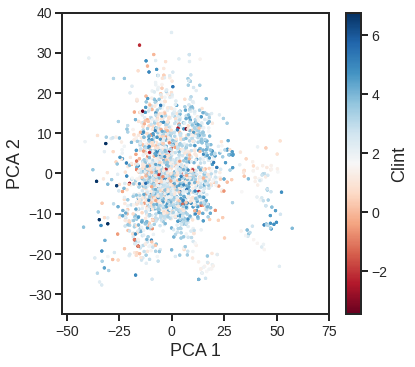

In [72]:
chem_df=df[df.label>-5]

fig = plt.figure(figsize=(6,5.5))
ax = plt.gca()
cm = plt.cm.get_cmap('RdBu')
cm=ax.scatter(chem_df.PCA_mord_0,\
        chem_df.PCA_mord_1, c=chem_df.label, alpha=1,s=5, \
        label='Mordred', cmap=cm)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
x=chem_df.PCA_mord_0
y=chem_df.PCA_mord_1
x_lim2=75
x_lim1=int(x.min()-np.abs(x.max())*0.1)-1
y_lim2=40
y_lim1=int(y.min()-np.abs(y.max())*0.1)-1
plt.xlim([x_lim1, x_lim2])
plt.ylim([y_lim1, y_lim2])

plt.tight_layout()
plt.colorbar(cm, label='Clint')
fig.savefig('output/pca_mord_features.svg')

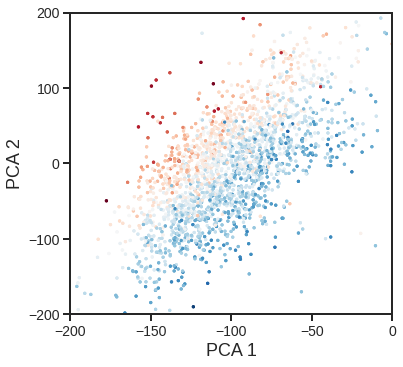

In [73]:
fig = plt.figure(figsize=(6,5.5))
ax = plt.gca()
cm = plt.cm.get_cmap('RdBu')
cm =ax.scatter(chem_df.PCA_ognn_0,\
        chem_df.PCA_ognn_1, c=chem_df.label, alpha=1,s=5, \
        label='OGNN', cmap=cm)

#     ax[1].legend()
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_xlim([-200, 0])
ax.set_ylim([-200, 200])
x_lim2=0
x_lim1=-200
y_lim2=200
y_lim1=-200
plt.xlim([x_lim1, x_lim2])
plt.ylim([y_lim1, y_lim2])
xstep=int((x_lim2-x_lim1)/4)
ystep=int((y_lim2-y_lim1)/4)
ax.xaxis.set_ticks(np.arange(x_lim1, x_lim2+xstep, xstep))
ax.yaxis.set_ticks(np.arange(y_lim1, y_lim2+ystep, ystep))

plt.tight_layout()
fig.savefig('output/pca_ognn_features.svg')